# Customer Churn Classification Project

## Business Understanding


- **Gender** -- Whether the customer is a male or a female
- **SeniorCitizen** -- Whether a customer is a senior citizen or not
- **Partner** -- Whether the customer has a partner or not (Yes, No)
- **Dependents** -- Whether the customer has dependents or not (Yes, No)
- **Tenure** -- Number of months the customer has stayed with the company
- **Phone Service** -- Whether the customer has a phone service or not
(Yes, No)
- **MultipleLines** -- Whether the customer has multiple lines or not (True, False)
- **InternetService** -- Customer's internet service provider (DSL, Fiber
Optic, No)
- **OnlineSecurity** -- Whether the customer has online security or not
(Yes, No, No Internet)
- **OnlineBackup** -- Whether the customer has online backup or not (Yes,
No, No Internet)
- **DeviceProtection** -- Whether the customer has device protection or
not (Yes, No, No internet service)
- **TechSupport** -- Whether the customer has tech support or not (Yes,
No, No internet)
- **StreamingTV** -- Whether the customer has streaming TV or not (Yes,
No, No internet service)
- **StreamingMovies** -- Whether the customer has streaming movies or not
(Yes, No, No Internet service)
- **Contract** -- The contract term of the customer (Month-to-Month, One
year, Two year)
- **PaperlessBilling** -- Whether the customer has paperless billing or
not (Yes, No)
- **Payment Method** -- The customer's payment method (Electronic check,
mailed check, Bank transfer(automatic), Credit card(automatic))
- **MonthlyCharges** -- The amount charged to the customer monthly
- **TotalCharges** -- The total amount charged to the customer
- **Churn** -- Whether the customer churned or not (Yes or No)

## Business Goal:
- To build a predictive achine learning model to fish out a customer likely to leave the organization.
- To identify the key indicators of churn.
- To propose rentention strategies that can be implemented to avert this problem

## 
1. What is the business use case?
Detecting potential churning customers

2. What type of ML problem are we dealing with?
Predictive ML

3. What are the business metrics?
Customer Churn rate (CTR), Customer Rention Rate, Monthly revenue

4. What are technical metrics we can use to assess the model’s performance?
F1-score, Recall, Accuracy

5. What kind of data is being used?	
Structured (numerical, categorical)

6. What is the machine learning problem formulation?
Binarry Classification

7. What are the relevant ML model types?
logistic Regression, Stochastic Gradient Descent, Random Forest

8. Are there any additional constraints or potential issues?	
bias

### Model target
- Accuracy 0.8 or above
- Recall above 0.8 

### Hypothesis
- **Null Hypothesis**: The monthly charges billed does not impact the number of customers who churn.
- **Alternate Hypothesis**: The monthly charges billed by the Telco impacts the number of customers who churn.


### Analytical Questions
- What is average amount charged per customer?
- Does the average monthly charge differ significantly between customers who churn and those who don't?
- Can we observe a trend in churn based on different ranges of monthly charges?
- What is the average tenure per customer?
- What is the sustomer churn trend based on monthly charges billed?
- `Is there a relationship between the tenure, the monthly charges and the churn rate?`

### Importation of relevant libraries

In [3]:
#for data manipulation
import pandas as pd
import numpy as np

#for access 
from dotenv import dotenv_values
import pyodbc as pc
import openpyxl

# for visualization
import matplotlib.pyplot as plt
import seaborn as sb

#for ML data preparatioon 
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, RobustScaler, OneHotEncoder, LabelEncoder

# for ML model training
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay,precision_recall_curve,roc_curve,roc_auc_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
 
#for data balancing
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as impipeline

#for model persistence
import joblib

# data display setting
pd.set_option('display.max_columns',50)


In [5]:
# save hidden content in variables
cred = dotenv_values('.env')

# extract individual values from cred dictionary
db = cred['DATABASE']
host = cred['SERVER']
user = cred['USERNAME']
password = cred['PASSWORD']

# build connection_string
connection_string = f"DRIVER={{SQL Server}};SERVER={host};DATABASE={db};UID={user};PWD={password}"

# build connection
nection = pc.connect(connection_string)

OperationalError: ('08001', '[08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]SQL Server does not exist or access denied. (17) (SQLDriverConnect); [08001] [Microsoft][ODBC SQL Server Driver][DBNETLIB]ConnectionOpen (Connect()). (53)')

### Load data

In [ ]:
# write sql queries
query1 = "SELECT * FROM dbo.LP2_Telco_churn_first_3000"

# load training data
first_df = pd.read_sql_query(query1, nection)
first_df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_11444\3680482883.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  first_df = pd.read_sql_query(query1, nection)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [ ]:
# view structure of df
first_df.shape

(3000, 21)

In [ ]:
# view structure of df
first_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [ ]:
#read evaluation data set
second_df = pd.read_excel('Telco-churn-second-2000.xlsx')
second_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


In [ ]:
# view structure of  second df
second_df.shape

(2000, 20)

In [ ]:
# view structure of second df
second_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


In [ ]:
#read test data set
third_df = pd.read_csv('LP2_Telco-churn-last-2000.csv')
third_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [ ]:
# view structure of third df
third_df.shape

(2043, 21)

In [ ]:
# view structure of third df
third_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


First and third_df both have to the target column 'Churn'. Both will be joined on the row axis to form the train_df. 
Second_df does not contain 'Churn' column, will be fed into the model as the test dataframe after model training, for the target to be predicted.

In [ ]:
#concatenate first_df and third_df
train_df = pd.concat([first_df,third_df], ignore_index= True)

In [ ]:
#re-assign test_df
test_df = second_df

### EDA and Brief Data Cleaning

#### Train_df

In [ ]:
# check structure of data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [ ]:
# view train data set
train_df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False


 OBSERVATION
- 21 columns 
- 5043 rows
- a few missing values
- Total charges is supposed to be a float not an object
- 17 categorical columns 
- 4 numeric columns

In [ ]:
# check for null values 
train_df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          5
Churn                 1
dtype: int64

Columns MultipleLines, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreaminTV, StreamingMovies, TotalCharges, and Churn have missing values

In [ ]:
# check for duplicates
train_df.duplicated().sum()

0

No duplicates found

In [ ]:
# verifying duplicates with unique identifier
train_df['customerID'].duplicated().value_counts()

customerID
False    5043
Name: count, dtype: int64

Confirmed. There are no duplicates present

In [ ]:
# convert TotalCharges to float
counts =train_df['TotalCharges'].value_counts()
counts[counts == 4]


TotalCharges
19.549999237060547    4
19.65                 4
45.29999923706055     4
19.9                  4
20.149999618530273    4
20.049999237060547    4
69.65                 4
Name: count, dtype: int64

3 blank spaces present

In [ ]:
# replace blanks with missing values
train_df.TotalCharges[train_df['TotalCharges'] == ' '] = np.nan

C:\Users\USER\AppData\Local\Temp\ipykernel_11444\424735107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.TotalCharges[train_df['TotalCharges'] == ' '] = np.nan


In [ ]:
#converting to float
train_df['TotalCharges'] = train_df['TotalCharges'].apply(lambda x: float(x))
#could not convert string to float: ' '
#conversion succesful

In [ ]:
# count distinct unique values
train_df.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                4
Dependents             4
tenure                73
PhoneService           4
MultipleLines          5
InternetService        3
OnlineSecurity         5
OnlineBackup           5
DeviceProtection       5
TechSupport            5
StreamingTV            5
StreamingMovies        5
Contract               3
PaperlessBilling       4
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4863
Churn                  4
dtype: int64

Some columns have more than the number of expected unique entry options. Have to be standardized.

In [ ]:
# view unique values
train_df['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [ ]:
# view unique values
train_df['gender'].unique()
#no issues

array(['Female', 'Male'], dtype=object)

In [ ]:
# view unique values
train_df['Partner'].unique()
#expected values are yes and no
# replace true and false values

array([True, False, 'No', 'Yes'], dtype=object)

In [ ]:
train_df['Partner'].replace(False, 'No', inplace= True )
train_df['Partner'].replace(True, 'Yes', inplace= True )
train_df['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
train_df['Dependents'].unique()
#expected values are yes and no
# replace true and false values

array([False, True, 'No', 'Yes'], dtype=object)

In [ ]:
train_df['Dependents'].replace(False, 'No', inplace= True )
train_df['Dependents'].replace(True, 'Yes', inplace= True )
train_df['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
train_df['PhoneService'].unique()
#expected values are yes and no
# replace true and false values

array([False, True, 'Yes', 'No'], dtype=object)

In [ ]:
train_df['PhoneService'].replace(False, 'No', inplace= True )
train_df['PhoneService'].replace(True, 'Yes', inplace= True )
train_df['PhoneService'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
train_df['MultipleLines'].unique()
#expected values are yes, no and no phone service
# replace true and false values
#what to do about missing values

array([None, False, True, 'No', 'No phone service', 'Yes'], dtype=object)

Under MultipleLines False and True values are not expected and need to be replaced.
- True values will be replaced with yes
- False values will be replaced with 'No' if its corresponding value in PhoneService is Yes
- False values will be replaced with 'No phone service' if its corresponding value in PhoneService is No

In [ ]:
# filter out df where MultipleLines is False
fal = train_df[train_df['MultipleLines'] == False]
#check unique values 
fal['PhoneService'].unique()
#all false values in MultipleLines column have their corresponding values in PhoneService as 'Yes'
#therefore:
train_df['MultipleLines'].replace(False, 'No', inplace= True )
train_df['MultipleLines'].replace(True, 'Yes', inplace= True )
train_df['MultipleLines'].unique()

array([None, 'No', 'Yes', 'No phone service'], dtype=object)

In [ ]:
train_df['InternetService'].unique()
#expected values are all present
#no issues

array(['DSL', 'Fiber optic', 'No'], dtype=object)

Under OnlineSecurity False and True values are not expected and need to be replaced.
- True values will be replaced with yes
- False values will be replaced with 'No' if its corresponding value in InternetService is DSL or Fibre Optic
- False values will be replaced with 'No internet service' if its corresponding value in InternetService is No

In [ ]:
train_df['OnlineSecurity'].unique()
#expected values are yes, no and No internet service
#replace true and false values

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [ ]:
# filter out df where Online Security is False
net = train_df[train_df['OnlineSecurity'] == False]
net['InternetService'].unique()
#all false values in OnlineSecurity column have their corresponding values in InternetService as 'DSL or Fiber Optic'
#therefore:
train_df['OnlineSecurity'].replace(False, 'No', inplace= True )
train_df['OnlineSecurity'].replace(True, 'Yes', inplace= True )
train_df['OnlineSecurity'].unique()

array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [ ]:
train_df['OnlineBackup'].unique()
#expected values are yes, no and No internet service
# replace true and false values

array([True, False, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [ ]:
# filter out df where Online Backup is False
net2 = train_df[train_df['OnlineBackup'] == False]
net2['InternetService'].unique()
#all false values in OnlineBackup column have their corresponding values in InternetService as 'DSL or Fiber Optic'
#therefore:
train_df['OnlineBackup'].replace(False, 'No', inplace= True )
train_df['OnlineBackup'].replace(True, 'Yes', inplace= True )
train_df['OnlineBackup'].unique()

array(['Yes', 'No', None, 'No internet service'], dtype=object)

In [ ]:
train_df['DeviceProtection'].unique()
#expected values are yes, no and No internet service
# replace true and false values

# filter out df where Device Protection is False
net3 = train_df[train_df['DeviceProtection'] == False]
net3['InternetService'].unique()
#all false values in DeviceProtection column have their corresponding values in InternetService as 'DSL or Fiber Optic'
#therefore:
train_df['DeviceProtection'].replace(False, 'No', inplace= True )
train_df['DeviceProtection'].replace(True, 'Yes', inplace= True )
train_df['DeviceProtection'].unique()


array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [ ]:
train_df['TechSupport'].unique()
#expected values are yes, no and No internet service
# replace true and false values

# filter out df where Tech Support is False
net4 = train_df[train_df['TechSupport'] == False]
net4['InternetService'].unique()

#all false values in TechSupport column have their corresponding values in InternetService as 'DSL or Fiber Optic'
#therefore:
train_df['TechSupport'].replace(False, 'No', inplace= True )
train_df['TechSupport'].replace(True, 'Yes', inplace= True )
train_df['TechSupport'].unique()


array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [ ]:
train_df['StreamingTV'].unique()
#expected values are yes, no and No internet service
# replace true and false values

# filter out df where Streaming TV is False
net5 = train_df[train_df['StreamingTV'] == False]
net5['InternetService'].unique()

#all false values in StreamingTV column have their corresponding values in InternetService as 'DSL or Fiber Optic'
#therefore:
train_df['StreamingTV'].replace(False, 'No', inplace= True )
train_df['StreamingTV'].replace(True, 'Yes', inplace= True )
train_df['StreamingTV'].unique()

array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [ ]:
train_df['StreamingMovies'].unique()
#expected values are yes, no and No internet service
# replace true and false values

# filter out df where Streaming Movies is False
net6 = train_df[train_df['StreamingMovies'] == False]
net6['InternetService'].unique()

#all false values in StreamingMovies column have their corresponding values in InternetService as 'DSL or Fiber Optic'
#therefore:
train_df['StreamingMovies'].replace(False, 'No', inplace= True )
train_df['StreamingMovies'].replace(True, 'Yes', inplace= True )
train_df['StreamingMovies'].unique()

array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [ ]:
train_df['Contract'].unique()
# no issues

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [ ]:
train_df['PaperlessBilling'].unique()
#expected values are yes and no
#replace True and False values

array([True, False, 'Yes', 'No'], dtype=object)

In [ ]:
train_df['PaperlessBilling'].replace(False, 'No', inplace= True )
train_df['PaperlessBilling'].replace(True, 'Yes', inplace= True )
train_df['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [ ]:
train_df['PaymentMethod'].unique()
#'Electronic check', 'Mailed check', 'Bank transfer (automatic)','Credit card (automatic)'
# No issues

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [ ]:
train_df['Churn'].unique()
#expected values are yes and no
# replace True and False

array([False, True, None, 'No', 'Yes'], dtype=object)

In [ ]:
train_df['Churn'].replace(False, 'No', inplace= True )
train_df['Churn'].replace(True, 'Yes', inplace= True )
train_df['Churn'].unique()

array(['No', 'Yes', None], dtype=object)

In [ ]:
# summarize numeric columns
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.400000,35.775000,70.550003,90.050003,118.650002
TotalCharges,5035.0,2302.062861,2269.483576,18.799999,417.675003,1401.150024,3862.000000,8670.100000


SeniorCitizen appears to be an encoded column, with 0 representing not a senior citizen and 1 representing a senior citizen.

In [ ]:
# summarize categorical columns
train_df.describe(include= 'object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,5043,5043,5043,5043,5043,4774,5043,4392,4392,4392,4392,4392,4392,5043,5043,5043,5042
unique,5043,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4,2
top,7590-VHVEG,Male,No,No,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,No
freq,1,2559,2585,3482,4554,2424,2248,2507,2231,2219,2472,2018,1982,2744,2996,1700,3706


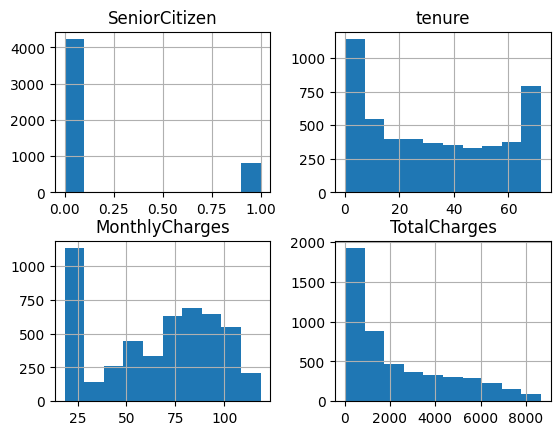

In [ ]:
# check distribution of numerical columns
train_df.hist();

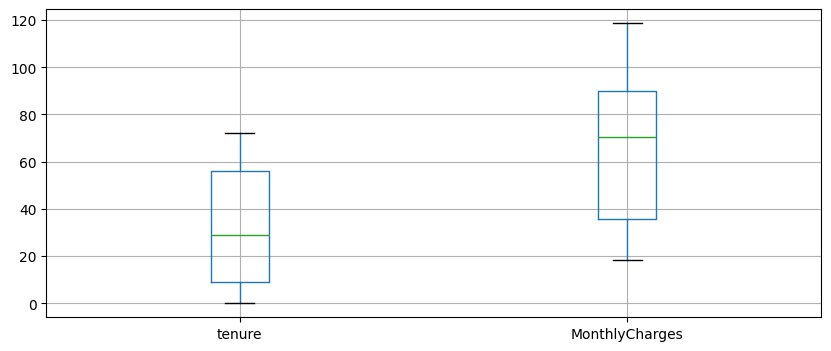

In [ ]:
# check outliers
train_df.boxplot(column= ['tenure', 'MonthlyCharges'], figsize = (10,4));

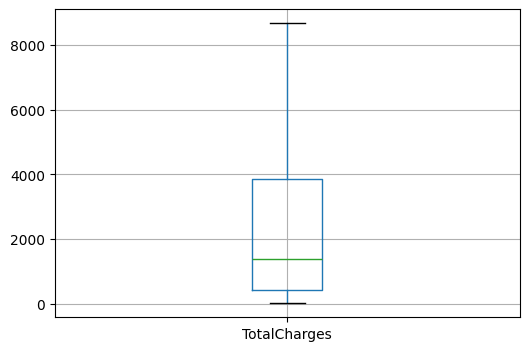

In [ ]:
# check outliers
train_df.boxplot(column= [ 'TotalCharges'], figsize = (6,4));

No outliers present in the numeric columns

EDA SUMMARY
- 21 columns 
- 5043 rows
- a few missing values
- no duplicates
- 17 categorical columns 
- 4 numeric columns
- no outliers

In [ ]:
# check null values
train_df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

Churn column has one null value which is insignificant. Hence let's drop that row.

In [ ]:
train_df['Churn'].unique()

array(['No', 'Yes', None], dtype=object)

In [ ]:
# filter null value
train_df[train_df['Churn'].isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2988,6295-OSINB,Male,0,Yes,No,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Electronic check,109.650002,7880.25,None


In [ ]:
# drop null value
train_df.dropna(subset= 'Churn', axis = 0, inplace= True)

In [ ]:
# verify drop
train_df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

### Univariate Analysis

In [ ]:
train_df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,None,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.50,No


#### Checking the distribution of Churn

Churn
No     3706
Yes    1336
Name: count, dtype: int64

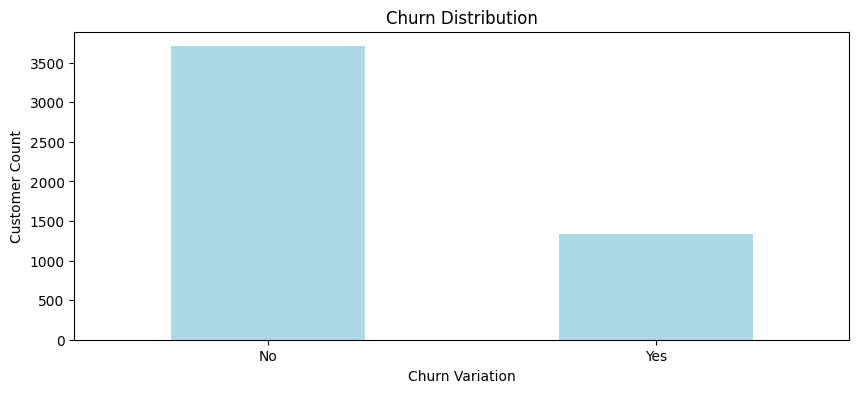

In [ ]:
# count frequency of distinct values
churning = train_df['Churn'].value_counts()

# plot Churn distribution
churning.plot(kind = 'bar', title= 'Churn Distribution', xlabel= 'Churn Variation', ylabel= 'Customer Count', color= 'lightblue', rot = 0.1, figsize= (10,4));
churning

Customers of the Telco are thrice as more likely to stay subscribed than they are to churn

#### Checking the distribution of Customers by their demographics
#### 1. By Gender

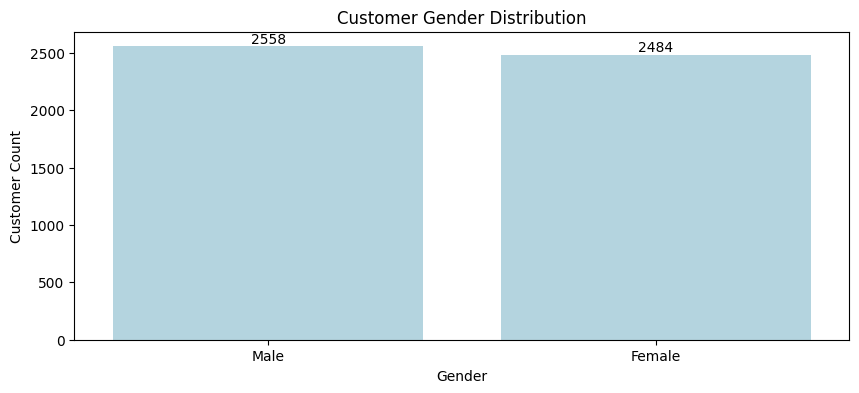

In [ ]:
# Count the occurrences of each gender category
sex = train_df['gender'].value_counts()

#set visual size
plt.figure(figsize=(10,4))

# Create the bar plot using Seaborn
ax = sb.barplot(x=sex.index, y=sex.values, color='lightblue')

# Set labels and title
plt.xlabel('Gender')
plt.ylabel('Customer Count')
plt.title('Customer Gender Distribution')

# Annotate each bar with its value
for i, count in enumerate(sex.values):
    plt.text(i, count, str(count), ha='center', va='bottom')

# Show the plot
plt.show()


Almost the same number of females are subscribed on to the Telco as males

#### 2. By Citizenship Status

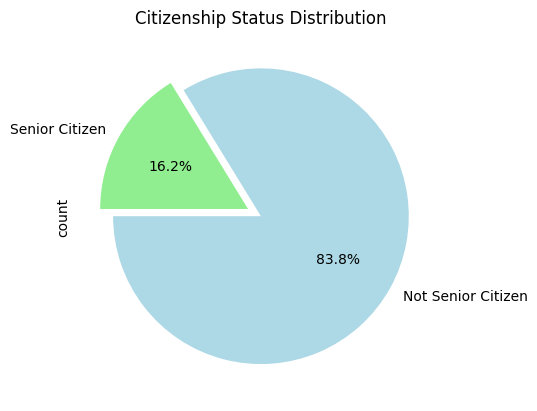

In [ ]:
# Count the occurrences of each SeniorCitizen category
citizen = train_df['SeniorCitizen'].value_counts()

# Create the pie chart
colors = ['lightblue', 'lightgreen']  # Define colors
explode = (0, 0.1)  # Explode the 2nd slice (to emphasize)
labels = ['Not Senior Citizen', 'Senior Citizen']  # Labels for the slices

# Plot the pie chart
citizen.plot(kind='pie', explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=180)

# Set title
plt.title('Citizenship Status Distribution')

# Show the plot
plt.show()


Majority of their customers are youthful

#### 3. By Dependents

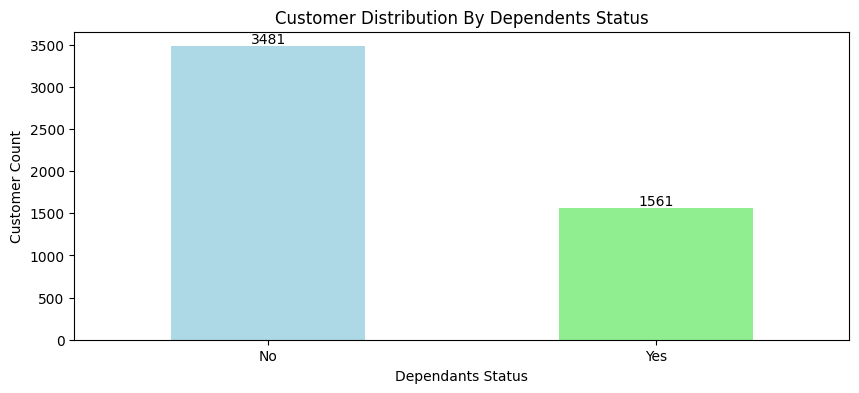

In [ ]:
# Count the occurrences of each Dependentsr category
Family = train_df['Dependents'].value_counts()
Family

# plot bar chart
ax = Family.plot(kind= 'bar', xlabel= 'Dependants Status', ylabel= 'Customer Count', color = colors, rot = 0.1, title = 'Customer Distribution By Dependents Status', figsize= (10,4))

# Add labels on each bar
for i, val in enumerate(Family):
    plt.text(i, val + 0.1, str(val), ha='center', va='bottom');

#### Checking Distribution of Customers by Monthly Charges

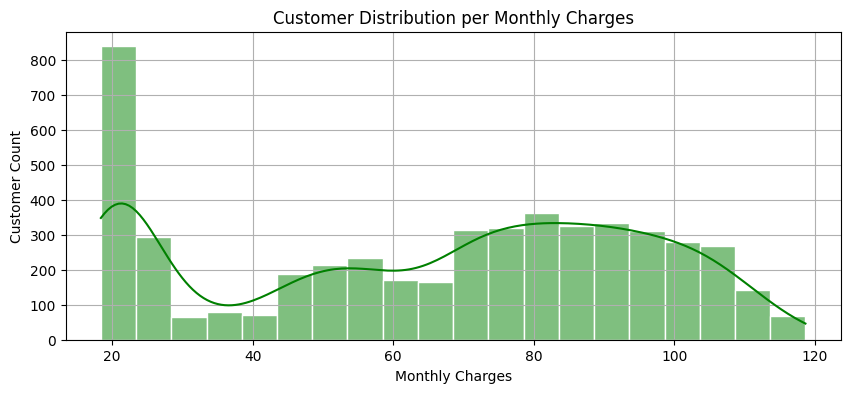

In [ ]:
# plot setting
plt.figure(figsize= (10,4))

#plot bar chart
sb.histplot(train_df['MonthlyCharges'], binwidth= 5, color = 'green', kde = True, edgecolor = 'white')

# set axis label
plt.xlabel('Monthly Charges')
plt.ylabel('Customer Count')

# set title
plt.title('Customer Distribution per Monthly Charges')

# display grid
plt.grid()

# show plot
plt.show()

find the subscription levels of the various peaks in monthly charges

There appears to be three major groups of subscribers per their monthly charges.
- the most popular group  with charges between 20-25
- the next widely varying group with charges between 70-120
- the last group with charges between 40-69

#### Checking Customer Distribution by Tenure

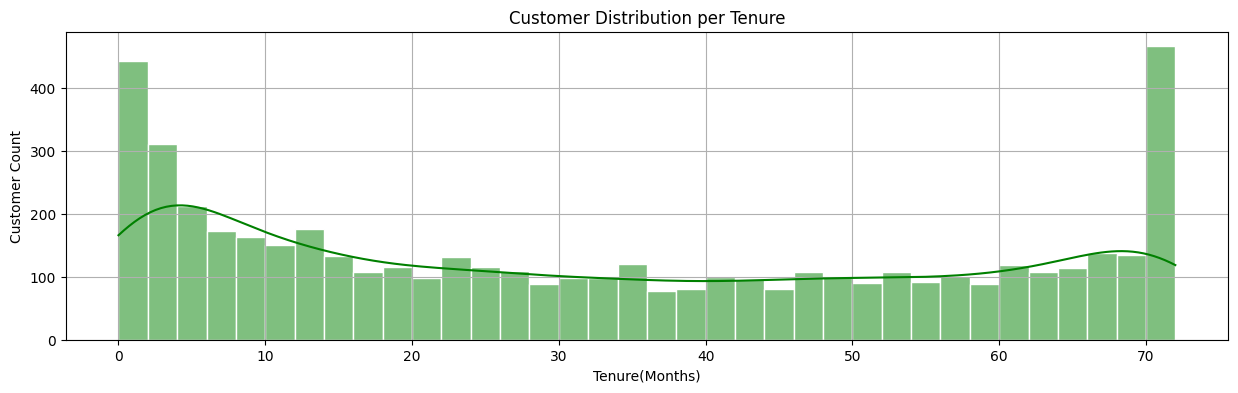

In [ ]:
# set visualisation settings
plt.figure(figsize= (15,4))

# plot bar chart
sb.histplot(train_df['tenure'], color = 'green', binwidth=2, kde=True, edgecolor = 'white')

# set axis label
plt.xlabel('Tenure(Months)')
plt.ylabel('Customer Count')

# set title
plt.title('Customer Distribution per Tenure')

# display grid
plt.grid()

# show plot
plt.show()

### Bivariate Analysis

#### Check the correlation between specific numeric columns

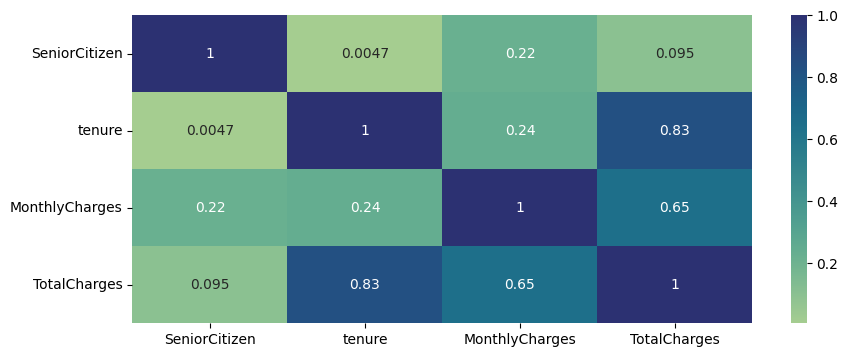

In [ ]:
# claculate correalation co-efficients 
correlation = train_df.corr(numeric_only= True)

# set visualization settings
plt.figure(figsize = (10,4))

#plot correlation matrix
sb.heatmap(correlation, annot=True, cmap= 'crest');

- SeniorCitizen has  positive but weak correlation with MonthlyCharges, a weaker correlation with TotalCharges and the weakest correlation with Tenure. 
- Tenure has the highest correlation with the total charges. The longer a customer stayed subscribed to more charges incurred.
- MonthlyCharges has a weak correlation with Tenure. It is possible that monthly charges does not influence to how long a customer stayed within the company.
- Therefore SeniorCitizenship and MonthlyCharges more likely may not influence how long a customer stayed with the Telco.

#### Lets verify this insight first by comparing the tenures of the churn variations

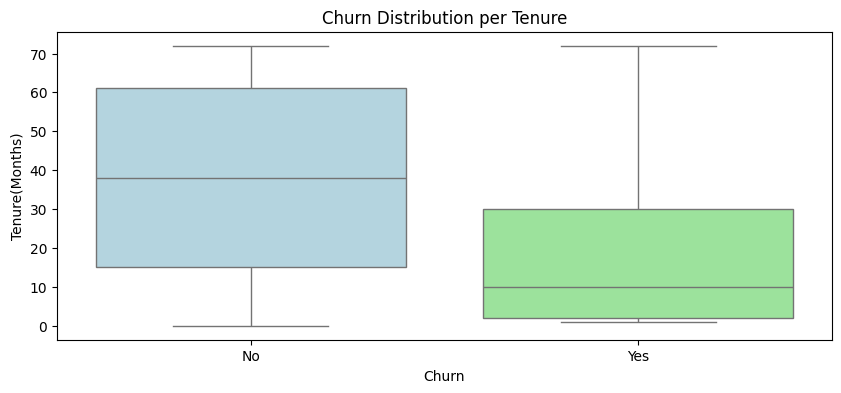

In [ ]:
# Define custom colors
custom_palette = {'No': 'lightblue', 'Yes': 'lightgreen'}

# set visual settings
plt.figure(figsize= (10,4))

# plot boxplot
sb.boxplot(x = 'Churn', y= 'tenure', data = train_df, hue='Churn', legend= False, palette= custom_palette)

# label axis
plt.ylabel('Tenure(Months)')

# set title
plt.title('Churn Distribution per Tenure');

Averagely Customers who churned had a shorter stay with the company than those who did not churn.
#### Since Tenure has a strong correlation with TotalCharges, lets check the effect of totalCharges on Customer Churning

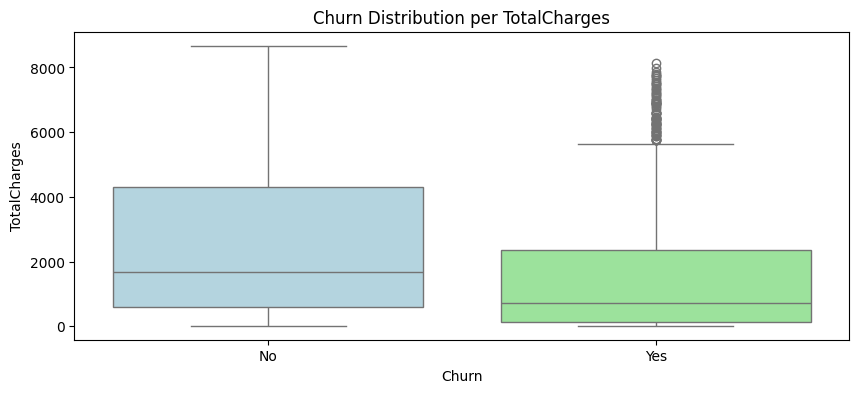

In [ ]:
# set visual settings
plt.figure(figsize= (10,4))

# plot boxplot
sb.boxplot(x = 'Churn', y= 'TotalCharges', data = train_df, hue='Churn', legend= False, palette= custom_palette)

# label axis
plt.ylabel('TotalCharges')

# set title
plt.title('Churn Distribution per TotalCharges');

Churned customers have on average lower total charges than Customers who did not. But the distribution seem to have a number of outliers to be handled
#### View the distribution of totalCharges

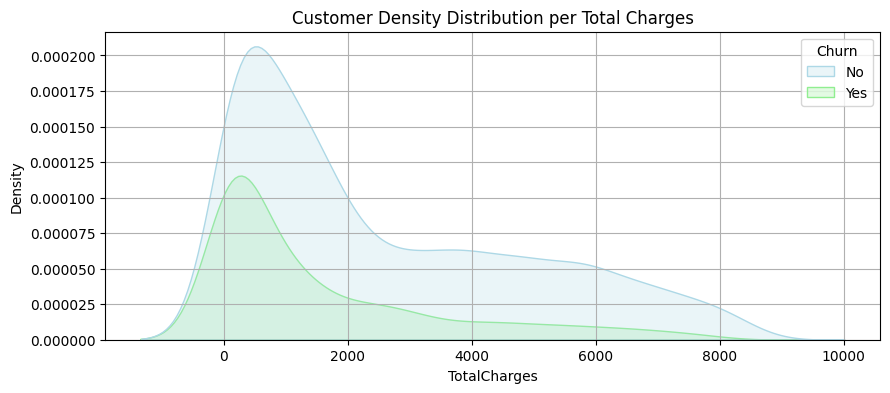

In [ ]:
# set visual settings
plt.figure(figsize= (10,4))

# plot kde
sb.kdeplot(data= train_df, x='TotalCharges', hue='Churn', palette=custom_palette, fill= True)

# set title
plt.title( 'Customer Density Distribution per Total Charges')

# set grid
plt.grid()

#show plot
plt.show()

Both heavily right-skewed distributions which will have to be scaled.
#### Lets verify Churn Distribution per Charges trend with MonthlyCharges

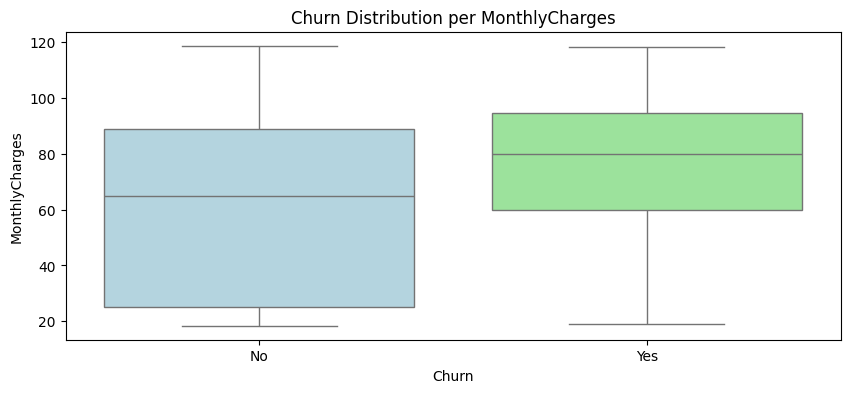

In [ ]:
# set visual setting
plt.figure(figsize= (10,4))

# plot boxplot
sb.boxplot(x = 'Churn', y= 'MonthlyCharges', data = train_df, hue='Churn', legend= False, palette= custom_palette)

# label axis
plt.ylabel('MonthlyCharges')

#set title
plt.title('Churn Distribution per MonthlyCharges');

Although, Churned customers had a shorter stay, they averagely had higher total charges.
#### What is the cause of this trend? What is the demographic of those who Churned? What kinds of services are they subscribed to?

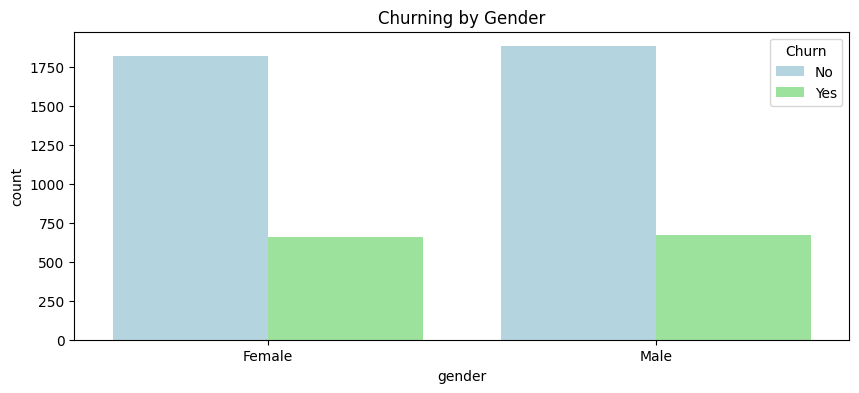

In [ ]:
# set visual setting
plt.figure(figsize=(10,4))
# plot countplot
sb.countplot(x= 'gender', hue = 'Churn', data= train_df, palette=custom_palette)
# set title
plt.title('Churning by Gender');

Each gender is equal likely to churn

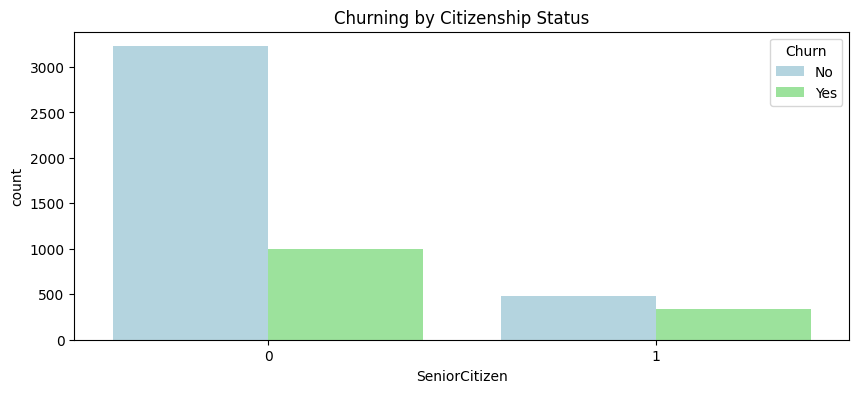

In [ ]:
# set visual setting
plt.figure(figsize=(10,4))
# plot countplot
sb.countplot(x= 'SeniorCitizen', hue = 'Churn', data= train_df, palette=custom_palette)
# set title
plt.title('Churning by Citizenship Status');

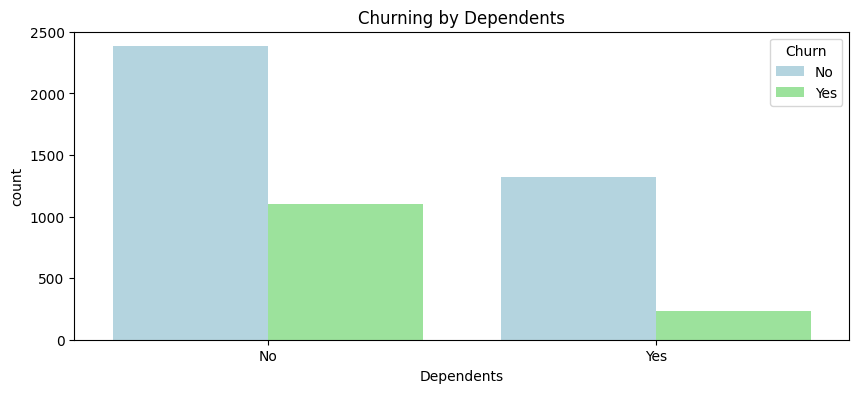

In [ ]:
# set visual setting
plt.figure(figsize=(10,4))

# plot count plot
sb.countplot(x= 'Dependents', hue = 'Churn', data= train_df, palette=custom_palette)

# set title
plt.title('Churning by Dependents');

Customers with no dependents are more likely to churn.

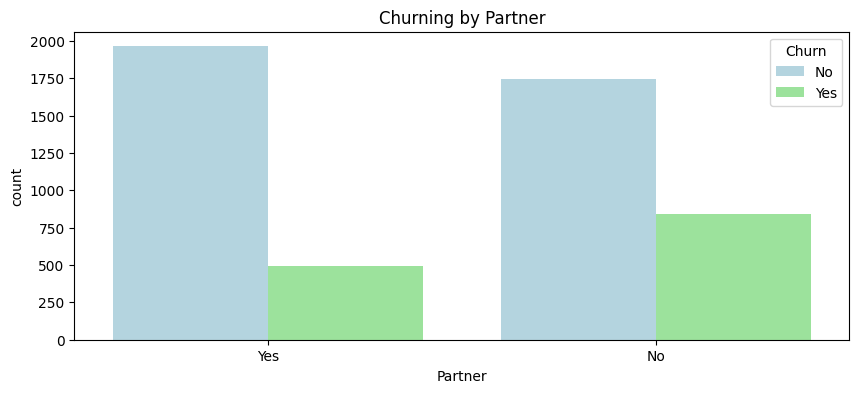

In [ ]:
# set visual setting
plt.figure(figsize=(10,4))

#plot countplot
sb.countplot(x= 'Partner', hue = 'Churn', data= train_df, palette=custom_palette)

#set title
plt.title('Churning by Partner');

- Interesting, Customers with no partners are also more likely to churn.
- Telco's churning customers are mostly singles with no dependents and partners

#### what Services are they subscribed to?


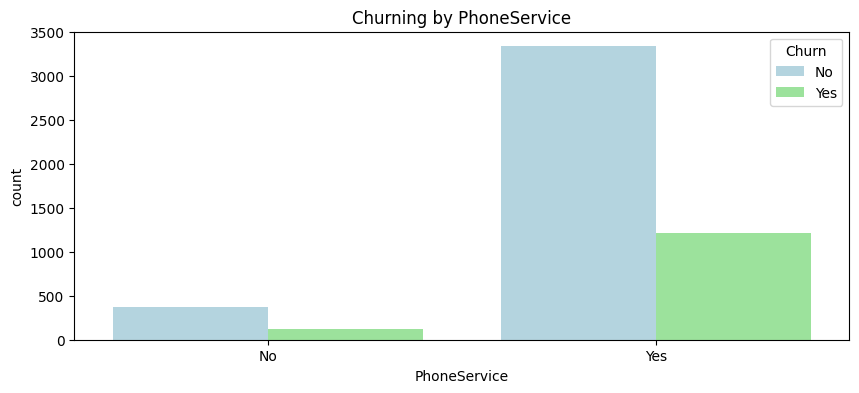

In [ ]:
# set visual setting
plt.figure(figsize=(10,4))

# plot countplot
sb.countplot(x= 'PhoneService', hue = 'Churn', data= train_df, palette=custom_palette)

# set title
plt.title('Churning by PhoneService');

Churned customers mostly subscribed to PhoneService

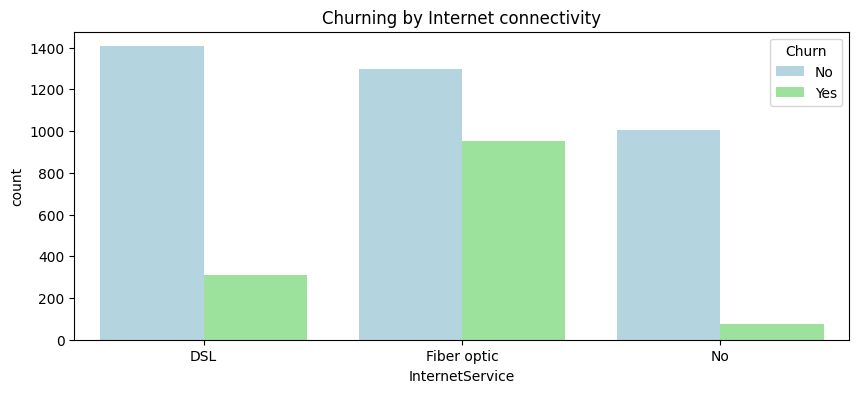

In [ ]:
#set visual setting
plt.figure(figsize=(10,4))
#plot countplot
sb.countplot(x= 'InternetService', hue = 'Churn', data= train_df, palette=custom_palette)
#set title
plt.title('Churning by Internet connectivity');

Churned customers mostly subscribed to Fiber Optic internet. Is the quality poor? Or is the cost of fiber optic the cause of their higher monthly charges?

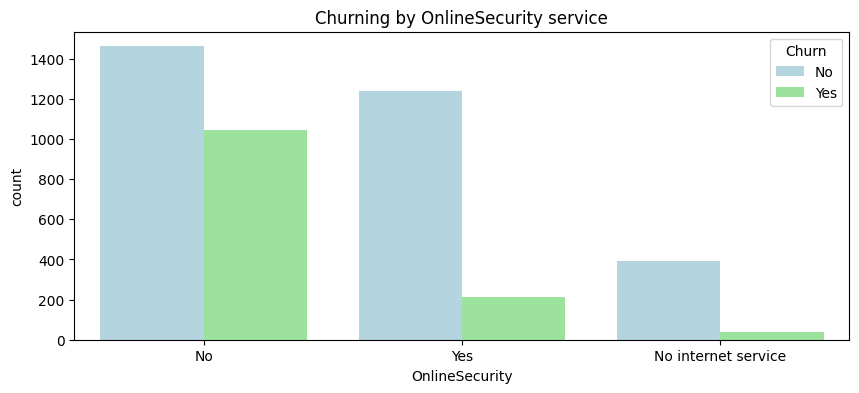

In [ ]:
#set visual setting
plt.figure(figsize=(10,4))
#plot countplot
sb.countplot(x= 'OnlineSecurity', hue = 'Churn', data= train_df, palette=custom_palette)
#set title
plt.title('Churning by OnlineSecurity service');

- Churned customers mostly did not subscribe to Online security, online backup, DeviceProtection, TechSupport services.
- About the same proportion of customer who churned subscribed to Streaming Services as those who did not churn.
- Additional service may not have been the reason for their higher monthly charges.
#### Lets look at their terms of payment


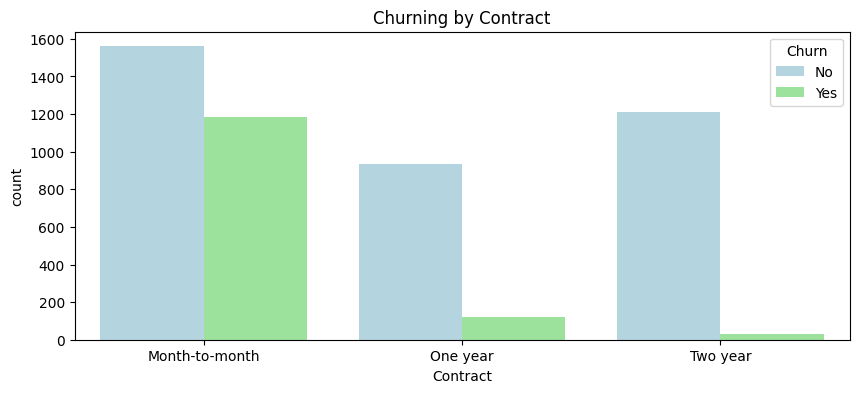

In [ ]:
#set visual settings
plt.figure(figsize=(10,4))
#plot countplot
sb.countplot(x= 'Contract', hue = 'Churn', data= train_df, palette=custom_palette)
#set title
plt.title('Churning by Contract');

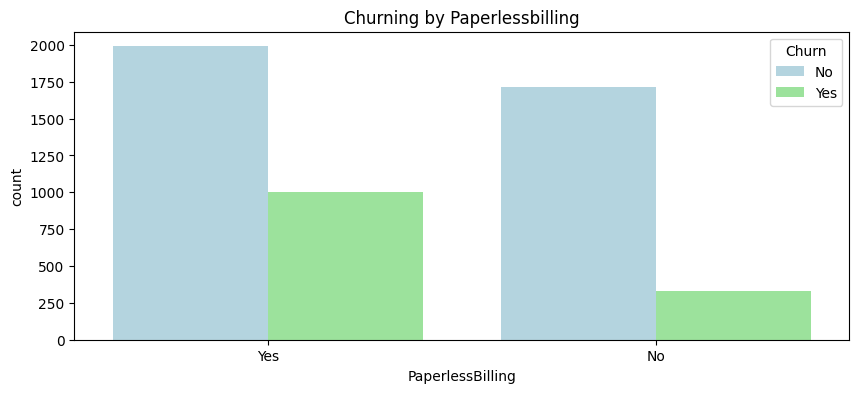

In [ ]:
#set visual setting
plt.figure(figsize=(10,4))
#plot countplot
sb.countplot(x= 'PaperlessBilling', hue = 'Churn', data= train_df, palette=custom_palette)
#set title
plt.title('Churning by Paperlessbilling');

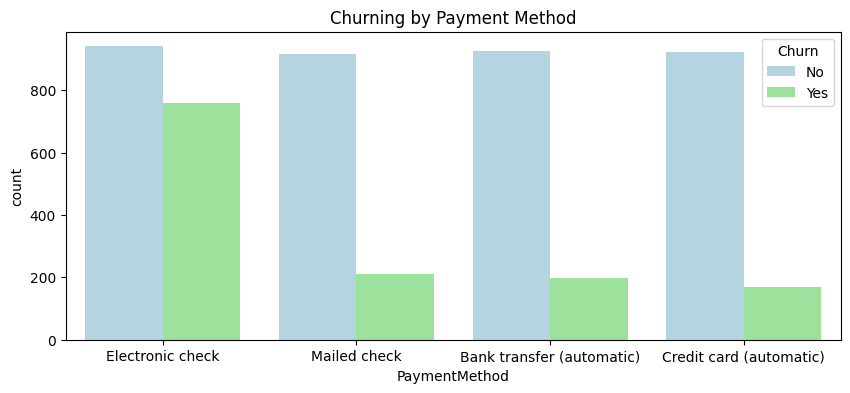

In [ ]:
#set visual setting
plt.figure(figsize=(10,4))
#plot countplot
sb.countplot(x= 'PaymentMethod', hue = 'Churn', data= train_df, palette=custom_palette)
#set title
plt.title('Churning by Payment Method');


Churned customers agreed opted to pay month-to-month mostly via electronic checks issued upon receipt of mostly paperless bills.
- Could the contract type have influenced their average monthly charge?

### Multivariate Analysis

<Figure size 1000x400 with 0 Axes>

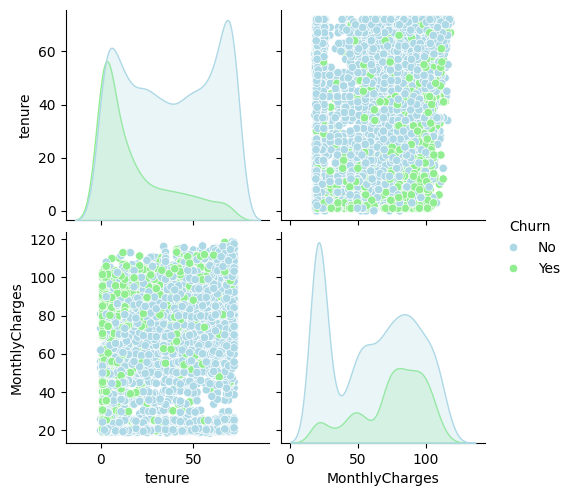

In [ ]:
#filter out columns
focus = train_df[['tenure', 'MonthlyCharges', 'Churn']]
#set visual setting
plt.figure(figsize=(10,4))
# plot pairplot
sb.pairplot(data= focus, hue= 'Churn' , palette= custom_palette);

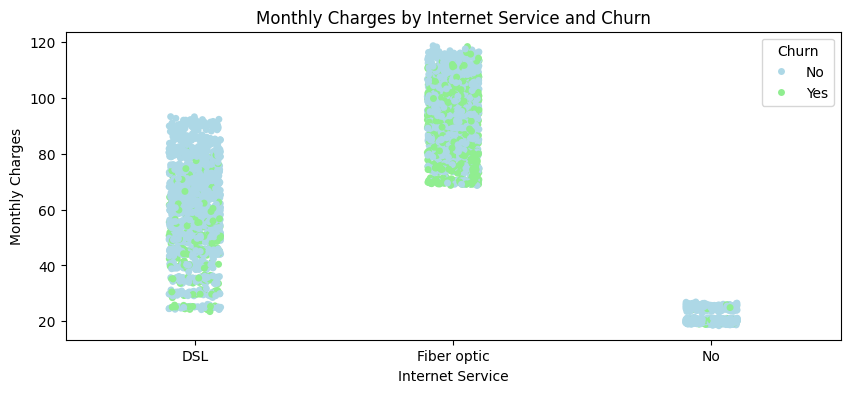

In [ ]:
# set plot setting
plt.figure(figsize=(10,4))
# plot stripplot
sb.stripplot(data= train_df, x= 'InternetService', y= 'MonthlyCharges', hue= 'Churn' , palette= custom_palette)
# Set labels and title
plt.xlabel('Internet Service')
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges by Internet Service and Churn');

A ghigher concentration of churned customers are found within the Fiber Optic Strip which generally has a higher cost compared to the other internet service options. Customers may have churned because the Fiber Optic internet service was expensive.

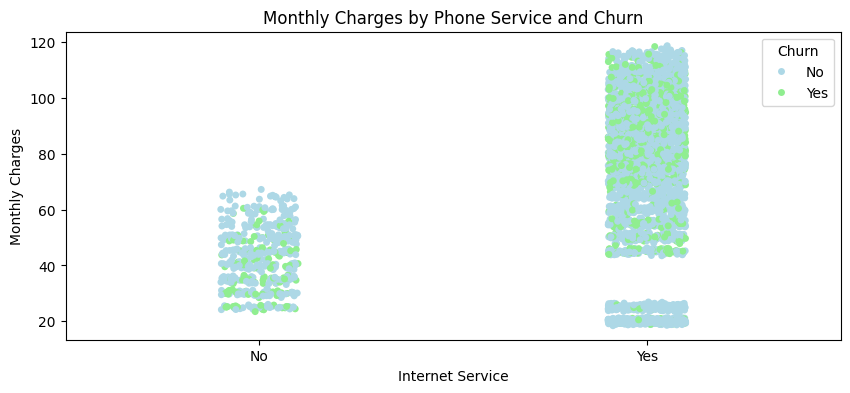

In [ ]:
#set plot setting
plt.figure(figsize=(10,4))
# plot stripplot
sb.stripplot(data= train_df, x= 'PhoneService', y= 'MonthlyCharges', hue= 'Churn' , palette= custom_palette)
# Set labels and title
plt.xlabel('Internet Service')
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges by Phone Service and Churn');

Phone Service also has an interestingly wide spread in cost for the Churned customers and Factors the goes into cost of phone service will have to be looked at.

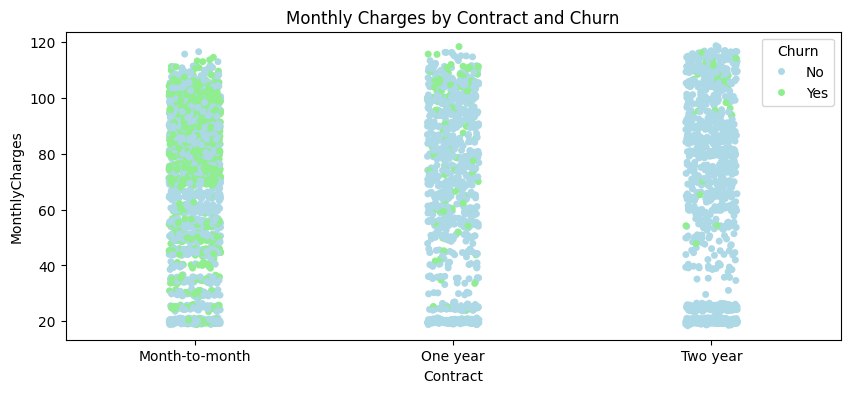

In [ ]:
# set visual settings
plt.figure(figsize=(10,4))
# plot stripplot
sb.stripplot(data= train_df, x= 'Contract', y= 'MonthlyCharges', hue= 'Churn' , palette= custom_palette)
# set title
plt.title('Monthly Charges by Contract and Churn');

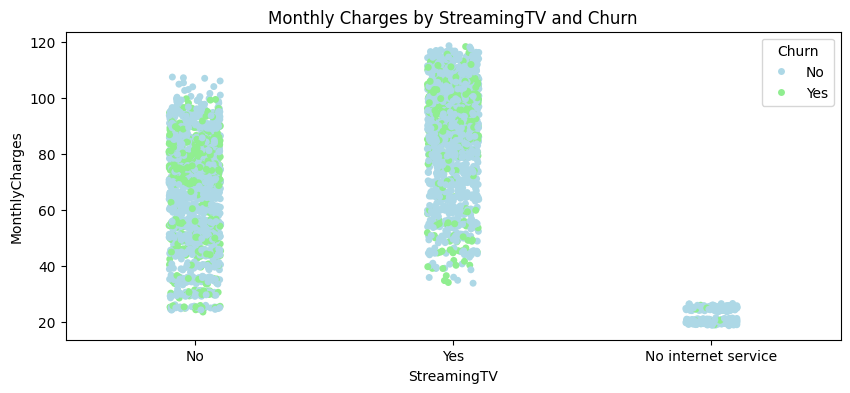

In [ ]:
# set plot settings
plt.figure(figsize=(10,4))
#plot stripplot
sb.stripplot(data= train_df, x= 'StreamingTV', y= 'MonthlyCharges', hue= 'Churn' , palette= custom_palette)
#set title
plt.title('Monthly Charges by StreamingTV and Churn');

Cost of streamingTV was relatively higher and churned customers are found at the upper end of this bracket. Churned customers who streamed were largely charged higher.

### Answers to Analytical Questions

1. What is the average monthly amount charged per customer?

In [ ]:

customer_count = train_df['customerID'].count()
total_monthly_charge = train_df['MonthlyCharges'].sum()
general_charge = total_monthly_charge/customer_count
print(f'The average monthly charge per customer is {general_charge:.2f}') 

The average monthly charge per customer is 65.08


2. Does the average monthly charge differ significantly between customers who churn and those who don't?

In [ ]:
#count customers per churn category
customer_churn_count = train_df['customerID'].groupby(train_df['Churn']).count()
#sum monthly charge per churn category
total_charge = train_df['MonthlyCharges'].groupby(train_df['Churn']).sum()
# calculate average monthly charge per churn category
average_charge = total_charge/customer_churn_count
average_charge

Churn
No     61.429682
Yes    75.211003
dtype: float64

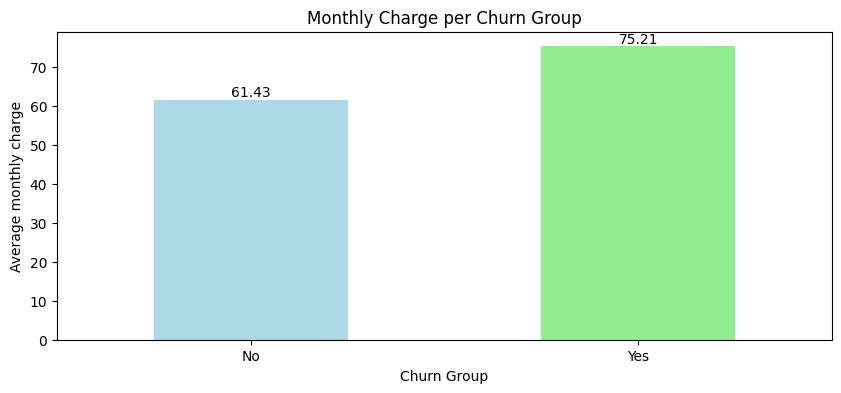

In [ ]:
#plot bar chart
ax = average_charge.plot(kind= 'bar', xlabel= 'Churn Group', ylabel= 'Average monthly charge', color = colors, rot = 0.1, title = 'Monthly Charge per Churn Group', figsize= (10,4))
# Add labels on each bar
for i, val in enumerate(average_charge):
    plt.text(i, val + 0.1, str(round(val, 2)), ha='center', va='bottom');

In [ ]:
#calculate percentage increment
churn_charge = average_charge[1]
non_churn_charge = average_charge[0]
increment = churn_charge - non_churn_charge
percentage = round((increment/non_churn_charge)* 100, 1)
percentage

C:\Users\USER\AppData\Local\Temp\ipykernel_11444\1524800096.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  churn_charge = average_charge[1]
C:\Users\USER\AppData\Local\Temp\ipykernel_11444\1524800096.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  non_churn_charge = average_charge[0]


22.4

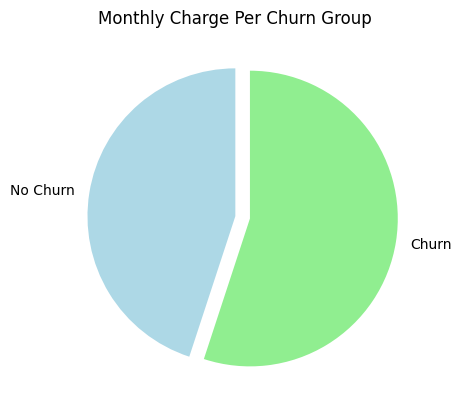

In [ ]:
colors = ['lightblue', 'lightgreen']  # Define colors
explode = (0, 0.1)  # Explode the 2nd slice (to emphasize)
labels = ['No Churn', 'Churn']  # Labels for the slices

# Plot the pie chart
average_charge.plot(kind='pie', explode=explode, labels=labels, colors=colors, startangle=90,)

# Set title
plt.title('Monthly Charge Per Churn Group')

# Show the plot
plt.show()

Yes. The average monthly charge differ significantly between customers who churn and those who don't. Proportionally, churned customers were charged 22% more than existing customers every month

3. Can we observe a trend in churn based on different ranges of monthly charges?

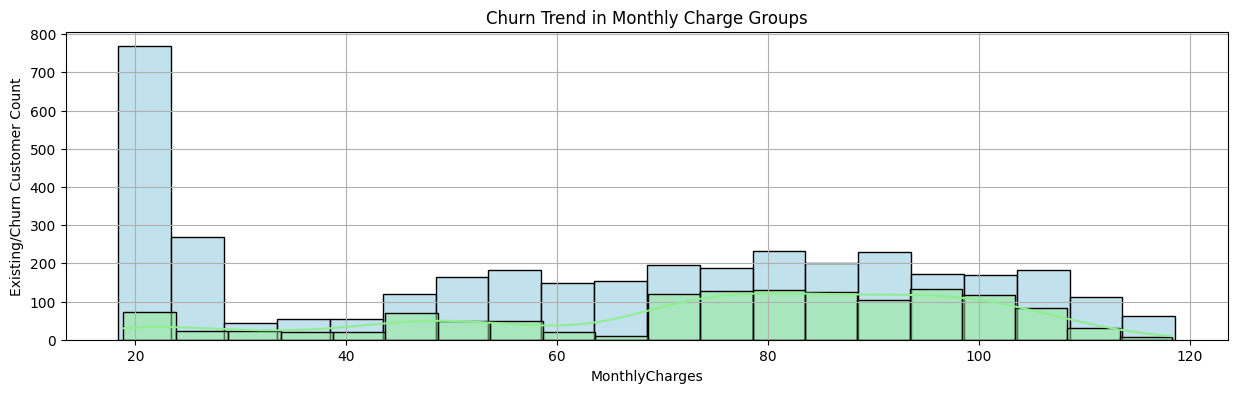

In [ ]:
# set plot settings
plt.figure(figsize= (15,4))

# Filter DataFrame for existing customers
no_churn_df = train_df[train_df['Churn'] == 'No']

# Plot histogram for monthly charges of existing customers
sb.histplot(no_churn_df['MonthlyCharges'], color = 'lightblue', binwidth=5, kde=False, edgecolor = 'black')

# Filter DataFrame for churned customer
churn_df = train_df[train_df['Churn'] == 'Yes']


# Plot histogram for monthly charges of churned customers on the same axis (overlay)
sb.histplot(churn_df['MonthlyCharges'], binwidth=5, color='lightgreen', edgecolor='black', kde= True)

# set label, title and grid
plt.xlabel('MonthlyCharges')
plt.ylabel('Existing/Churn Customer Count')
plt.title('Churn Trend in Monthly Charge Groups')
plt.grid()

#show plot
plt.show()

Proportion of churned customers to existing customers generally increases with increasing monthly charges

4. What is the average tenure per customer?

In [ ]:
# sum tenure per churn category
group_tenure = train_df['tenure'].groupby(train_df['Churn']).sum()

# # find average
average_tenure = (group_tenure/customer_count).astype(int)

# print average tenure
average_tenure

Churn
No     27
Yes     4
Name: tenure, dtype: int32

5.  What is the customer churn trend based on tenure?

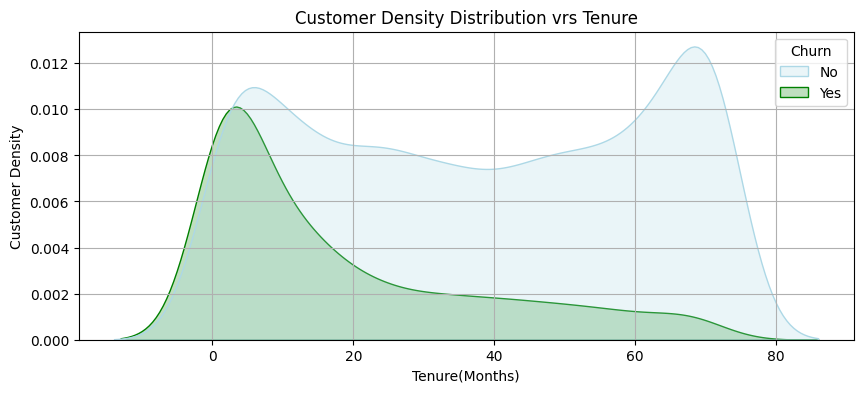

In [ ]:
# reset colour yes churn group
custom_palette['Yes'] = 'green'

# set visual settings
plt.figure(figsize= (10,4))

# plot kde
sb.kdeplot(data= train_df, x='tenure', hue='Churn', palette=custom_palette, fill= True)

# set title, labels and grid
plt.title( 'Customer Density Distribution vrs Tenure')
plt.xlabel('Tenure(Months)')
plt.ylabel('Customer Density')
plt.grid()

# show plot
plt.show()

Majority of Churn customers leave before the 1st 20 months of subscription.

#### FINAL INSIGHT
- There is a significant differences in charges for existing customers and those who churned.
- Customer who churned were billed heavier and this is be a possible cause of their churning.
- As charges increased, the churn rate increases and average customer tenure decreases.
- Majority of customer churning happened during the first 20 months post subscription to the Telco's services.

#### HYPOTHESIS EVALUATION
- The trend observed in ratio of exisitng/churned customers with increasing monthly charges suggests the existence of a impact(relationship) between monthly charges billed to the churned customers and the rate at which they churn.
- Therefore, there is evidence to support and accept the null Hypothesis.
- Further statistical analysis have been performed to confirm and possibly describe the nature of this impact.



### Feature Engineering and Data Preparation

In [ ]:
# verify structure of your data
train_df.shape

(5042, 21)

#### Split data into Feature(X) and target(y) sets
For X drop columns customerID as its an index for verification and no longer needed to train predictive models, and churn as it is the result to be test hence belongs to the target set.

In [ ]:
# assign X and y sets
X = train_df.drop(columns = ['customerID', 'Churn'], axis=1)
y = train_df['Churn']

#### Splitting data sets into train and trial components

In [ ]:
X_train, X_trial, y_train, y_trial = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# select numeric columns
numeric = X.select_dtypes(include= 'number').columns
numeric

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [ ]:
# set categorical columns
categorical = X.select_dtypes(include = 'object').columns
categorical

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

#### PIPELINE DEVELOPMENT: Feature Preparation

In [ ]:
# Create class to transform data sets
class LogTransformer():
    def __init__(self, constant=1e-5):
        self.constants = constant

    def fit(self, x, y = None):
        return self
    
    def transform(self, x):
        return np.log1p(x + self.constants)
    
# create plipeline for numeric columns
numeric_pipeline = Pipeline(steps = [
    ('numeric_imputer', SimpleImputer(strategy = 'median')),
    ('log_tranformer', FunctionTransformer(LogTransformer().transform)),
    ('scaler', RobustScaler())
])

In [ ]:
# create pipeline for categorical columns
categorical_pipeline = Pipeline(steps = [
    ('catergory_imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder())
])

In [ ]:
# create preprocessor pipeline
preprocessor = ColumnTransformer([
    ('numeric_pipeline', numeric_pipeline, numeric),
    ('categorical_pipeline', categorical_pipeline, categorical)
])

#### Label Preparation

In [ ]:
target_encoder = LabelEncoder()

# encode categorical target columns
y_train_encoded = target_encoder.fit_transform(y_train)
y_trial_encoded = target_encoder.transform(y_trial)

### Modeling

#### Random Forest
- Ensemble combining weak classifiers with stronger to give better prediction

In [ ]:
# Develop Pipeline for Random Forest Classifier Model
Random_forest = Pipeline( steps = [
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state = 42))
])

# Train Random Forest Classifier Model
model = Random_forest.fit(X_train, y_train_encoded)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_tranformer',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001D1B280F4F0>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model', RandomForestClassifier(random_state=42))])

Prediction

In [ ]:
y_pred = model.predict(X_trial)

Evaluation

In [ ]:
report = classification_report(y_trial_encoded, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       742
           1       0.61      0.49      0.55       267

    accuracy                           0.78      1009
   macro avg       0.72      0.69      0.70      1009
weighted avg       0.77      0.78      0.77      1009



#### Logistic Regression
- Simple and works well when relationship between feature and target are roughly linear


In [ ]:
# Develop Pipeline for Logistic Regression Model
Log_Regression = Pipeline( steps = [
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter= 200, random_state = 42))
])

# Train Logistic Regression Model
model2 = Log_Regression.fit(X_train, y_train_encoded)
model2
# convergence issue , increase max_iter from default 100 to 200

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_tranformer',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001D1B280F4F0>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model', LogisticRegression(max_iter=200, random_state=42))])

Prediction

In [ ]:
y_pred2 = model2.predict(X_trial)

Evaluation

In [ ]:
report2 = classification_report(y_trial_encoded, y_pred2)
print(report2)

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       742
           1       0.65      0.55      0.60       267

    accuracy                           0.80      1009
   macro avg       0.75      0.72      0.73      1009
weighted avg       0.79      0.80      0.80      1009



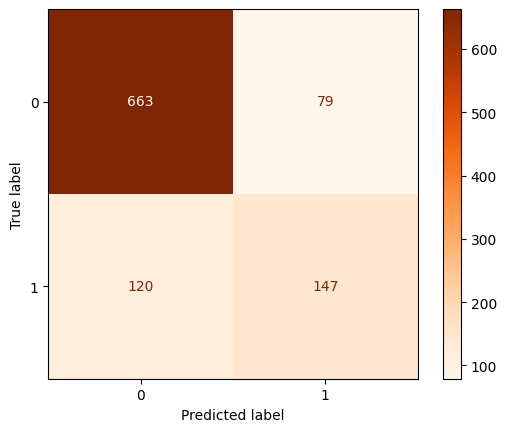

In [ ]:
# get confusion matrix for Logistic Regression 
matrix = confusion_matrix(y_trial_encoded, y_pred2)

#display confusin matrix
display = ConfusionMatrixDisplay(matrix)
display.plot(cmap= 'Oranges')
plt.show()

Does not perform too well with predicting the churn. That's the focus. Need to optimize the prediction of Churn

#### K-Nearest Neighbors
- Works well on small data sets

In [ ]:
# Develop Pipeline for K-Nearest Neighbors Model
KN_N = Pipeline( steps = [
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier())
])

# Train K-Nearest Neighbors Model
model3 = KN_N.fit(X_train, y_train_encoded)
model3

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_tranformer',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001D1B280F4F0>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model', KNeighborsClassifier())])

Prediction

In [ ]:
y_pred3 = model3.predict(X_trial)

Evaluation

In [ ]:
report3 = classification_report(y_trial_encoded, y_pred3)
print(report3)

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       742
           1       0.58      0.51      0.54       267

    accuracy                           0.77      1009
   macro avg       0.70      0.69      0.70      1009
weighted avg       0.76      0.77      0.77      1009



#### SGD Classifier


In [ ]:
# Develop Pipeline for SDG Classifer Model
SGD = Pipeline( steps = [
    ('preprocessor', preprocessor),
    ('model', SGDClassifier(random_state = 42))
])

# Train SDG Classifer Model
model4 = SGD.fit(X_train, y_train_encoded)
model4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_tranformer',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001D1B280F4F0>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model', SGDClassifier(random_state=42))])

Prediction

In [ ]:
y_pred4 = model4.predict(X_trial)

Evaluation

In [ ]:
report4 = classification_report(y_trial_encoded, y_pred4)
print(report4)

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       742
           1       0.62      0.64      0.63       267

    accuracy                           0.80      1009
   macro avg       0.74      0.75      0.75      1009
weighted avg       0.80      0.80      0.80      1009



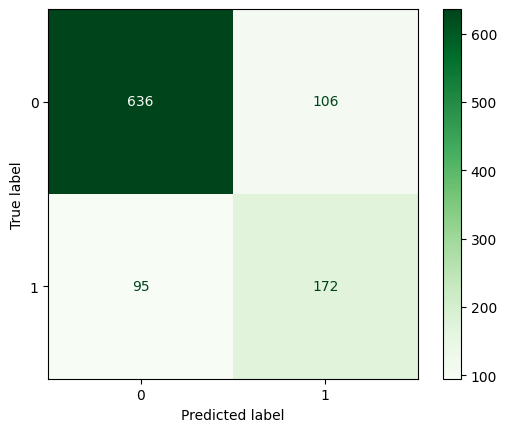

In [ ]:
# get confusion matrix for SGD Classifier
matrix2 = confusion_matrix(y_trial_encoded, y_pred4)

# display confusion matrix
display2 = ConfusionMatrixDisplay(matrix2)
display2.plot(cmap= 'Greens')
plt.show()

Does better at predicting Churn than Logistic Regression model

#### Support Vector Machine
- Works well on small to medium-sized data sets

In [ ]:
# Develop Pipeline for SVM Model
Support_Vector = Pipeline( steps = [
    ('preprocessor', preprocessor),
    ('model', SVC(random_state = 42))
])

# Train SVM Model
model5 = Support_Vector.fit(X_train, y_train_encoded)
model5

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_tranformer',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001D1B280F4F0>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', '...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model', SVC(random_state=42))])

Prediction

In [ ]:
y_pred5 = model5.predict(X_trial)

Evaluation

In [ ]:
report5 = classification_report(y_trial_encoded, y_pred5)
print(report5)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       742
           1       0.68      0.54      0.60       267

    accuracy                           0.81      1009
   macro avg       0.76      0.72      0.74      1009
weighted avg       0.80      0.81      0.80      1009



Highest  metrics so far

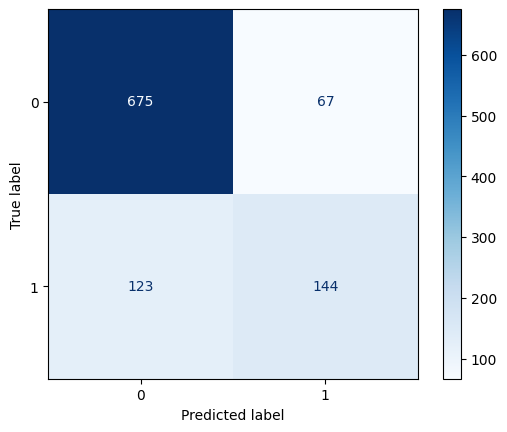

In [ ]:
# get confusion matrix for SVM model
matrix3 = confusion_matrix(y_trial_encoded, y_pred5)

# display confusion matrix
display3 = ConfusionMatrixDisplay(matrix3)
display3.plot(cmap= 'Blues')
plt.show()

OBSERVATION:
- In terms of Accuracy, three models namely Logistic regression, SGD and SVM models performed up to target ( Accuracy > or = 80)
- SVM had the best Accuracy so far.
- Generally, models were better at predicting non- churn customers than churn. Probably because the target data is not balance between the two churn category.
- With our business goal in mind, our preferred model should be one with with a higher f1 score and particularly better recall for the class 1(churn).
- Looking at the recall, best model is SGD model(0.64), followed by logistic regression(0.55) and SVM (0.54) in descending order. Meaning amongst the 3 models, SGD  model is more likely to predict a higher portion of churn customers who truly churned.

#### Model Comparison and selection

In [ ]:
def model_compare(x, y):
    # create list of classification models
    models = [
    ('forest_classifier', RandomForestClassifier(random_state=42)),
    ('regression_classifier', LogisticRegression(random_state=42, max_iter= 200)),
    ('KNN_classifer', KNeighborsClassifier()),
    ('SGD_classifier', SGDClassifier(random_state=42)),
    ('SVM_classifier', SVC(random_state=42))
]
    
    for name, model in models:
        model_pipeline = Pipeline( steps = [
        ('preprocessor', preprocessor),
        ('model', model)
        ])
        model_pipeline.fit(x,y)
        trial_pred = model_pipeline.predict(X_trial)

    # print classification report for each model
        print(f'Performance report of {name}\n{classification_report(y_trial_encoded, trial_pred)}\n{"-"*50}')  

In [ ]:
# apply function to train data
model_compare(X_train, y_train_encoded)

Performance report of forest_classifier
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       742
           1       0.61      0.49      0.55       267

    accuracy                           0.78      1009
   macro avg       0.72      0.69      0.70      1009
weighted avg       0.77      0.78      0.77      1009

--------------------------------------------------
Performance report of regression_classifier
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       742
           1       0.65      0.55      0.60       267

    accuracy                           0.80      1009
   macro avg       0.75      0.72      0.73      1009
weighted avg       0.79      0.80      0.80      1009

--------------------------------------------------
Performance report of KNN_classifer
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       742
           1   

#### Balancing Data sets

In [ ]:
# balancing data by Random Oversampling
sampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train_encoded)

In [ ]:
# apply function to balanced data
model_compare(X_train_resampled,y_train_resampled)

Performance report of forest_classifier
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       742
           1       0.58      0.56      0.57       267

    accuracy                           0.78      1009
   macro avg       0.71      0.71      0.71      1009
weighted avg       0.77      0.78      0.77      1009

--------------------------------------------------
Performance report of regression_classifier
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       742
           1       0.51      0.82      0.63       267

    accuracy                           0.74      1009
   macro avg       0.71      0.77      0.71      1009
weighted avg       0.81      0.74      0.76      1009

--------------------------------------------------
Performance report of KNN_classifer
              precision    recall  f1-score   support

           0       0.88      0.66      0.76       742
           1   

Performance report of SVM_classifier
              precision    recall  f1-score   support

           0       0.91      0.74      0.81       742
           1       0.52      0.79      0.63       267

    accuracy                           0.75      1009
   macro avg       0.71      0.76      0.72      1009
weighted avg       0.80      0.75      0.76      1009

--------------------------------------------------


OBSERVATION:
- In terms of Accuracy, Logistic regression, SGD and SVM models now performed below target ( Accuracy > or = 80) on the balanced data
- SGD now has the best Accuracy so far amongst the potential three.
- Models were still better at predicting non- churn customers than churn. 
- Balancing the data increased recall at the expense of precision, resulting in a slightly increased f1-score in general
- With our business goal in mind, our preferred model should be one with with a higher f1 score and particularly better recall for the class 1(churn).
- Recall  and f1-score-wise, best model now becomes logistic regression (0.82, 0.76), followed by SGD model (0.79, 0.77) and SVM (0.79, 0.76) in descending order. Meaning amongst the 3 models, logistic regression  model is more likely to predict a higher portion of churn customers who truly churned.

#### Feature Importance and selection

In [ ]:
selection = SelectKBest(mutual_info_classif, k= 'all')

def updated_model_compare(x,y):
    models = [
    ('forest_classifier', RandomForestClassifier(random_state=42)),
    ('regression_classifier', LogisticRegression(random_state=42, max_iter= 200)),
    ('KNN_classifer', KNeighborsClassifier()),
    ('SGD_classifier', SGDClassifier(random_state=42)),
    ('SVM_classifier', SVC(random_state=42))
]

    for name, model in models:
        model_pipeline = Pipeline( steps = [
        ('preprocessor', preprocessor),
        # after trying a series of number of features, k = all gave the best performance
        ('feature_selection', selection ),
        ('model', model)
        ])
        model_pipeline.fit(x,y)
        trial_pred = model_pipeline.predict(X_trial)
   
        print(f'Performance report of {name}\n{classification_report(y_trial_encoded, trial_pred)}\n{"-"*50}') 

In [ ]:
updated_model_compare(X_train_resampled,y_train_resampled)

Performance report of forest_classifier
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       742
           1       0.58      0.56      0.57       267

    accuracy                           0.78      1009
   macro avg       0.71      0.71      0.71      1009
weighted avg       0.77      0.78      0.77      1009

--------------------------------------------------
Performance report of regression_classifier
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       742
           1       0.51      0.82      0.63       267

    accuracy                           0.74      1009
   macro avg       0.71      0.77      0.71      1009
weighted avg       0.81      0.74      0.76      1009

--------------------------------------------------
Performance report of KNN_classifer
              precision    recall  f1-score   support

           0       0.88      0.66      0.76       742
           1   

depending on the number of specified importance features, besgt performing model(recall) shifts between  logistic regression and SGD

#### Advanced model evaluation and performance visualization
ROC Curve

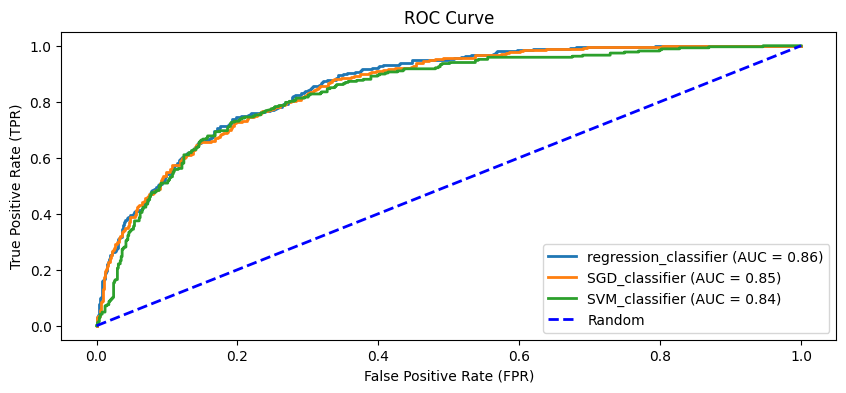

In [ ]:
potential_models = [
    ('regression_classifier', LogisticRegression(random_state=42, max_iter= 200)),
    ('SGD_classifier', SGDClassifier(loss='log_loss',random_state=42)),
    ('SVM_classifier', SVC(kernel='rbf', random_state=42, probability=True))
]

fig, ax = plt.subplots(figsize = (10, 4))
roc_curve_data = {}
all_pipeline = {}

for model_name, model in potential_models:
    pipeline = Pipeline( steps = [
        ('preprocessor', preprocessor),
        ('feature_selection', selection ),
        ('model', model)
        ])
    pipeline.fit(X_train_resampled, y_train_resampled)

    # get predicted probabilities
    y_pred_prob = pipeline.predict_proba(X_trial)[:,1]
    all_pipeline[model_name] = pipeline

    #compute ROC curve
    fpr, tpr, threshold = roc_curve(y_trial_encoded, y_pred_prob)

    #compute AUC score
    AUC_score = roc_auc_score(y_trial_encoded, y_pred_prob)

    # create roc dataframe
    roc_curve_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Threshold': threshold})

    # update roc_curve_data
    roc_curve_data[model_name] = roc_curve_df


    # Plot ROC Curve
    ax.plot(fpr, tpr, lw=2, label= f'{model_name} (AUC = {AUC_score:.2f})')
ax.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Random')
ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('ROC Curve')
ax.legend()
plt.show()

AUC and a ROC curve is used to describe the accuracy of the classification models. ROC curves closeser to the upper left corner indicates higher TPR and sensitivity(recall). All models tested have AUC scores of about the same intensity. 
Will focus on model with AUC highest score (Logistic Regression model) for hyperparameter optimization.

In [ ]:
# retrieve ROC_curve_data for selected model
roc_curve_data['regression_classifier'].iloc[230:260]

,False Positive Rate,True Positive Rate,Threshold
230,0.327493,0.876404,0.456522
231,0.339623,0.876404,0.440592
232,0.339623,0.883895,0.435716
233,0.342318,0.883895,0.430952
234,0.342318,0.895131,0.428078
235,0.350404,0.895131,0.421156
236,0.350404,0.898876,0.420952
237,0.355795,0.898876,0.416738
238,0.355795,0.902622,0.415991
239,0.366577,0.902622,0.400420


In [ ]:
#assessing effect on threshold on model confusion matrix


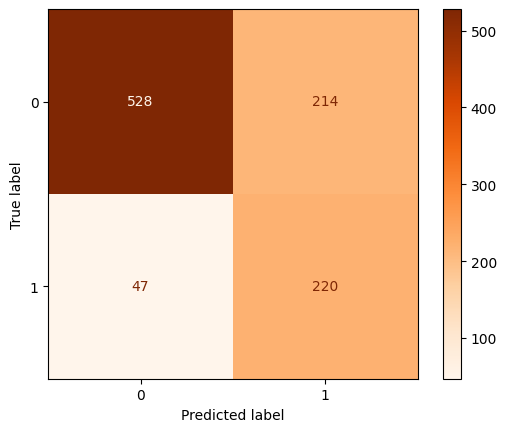

In [ ]:
# Checking model prediction with default threshold
# Develop Pipeline for Logistic Regression Model
Log_Regression = Pipeline( steps = [
    ('preprocessor', preprocessor),
    ('feature_selection', selection),
    ('model', LogisticRegression(max_iter= 200, random_state = 42))
])

# Train Logistic Regression Model
log_model = Log_Regression.fit(X_train_resampled, y_train_resampled)
log_pred = log_model.predict(X_trial)


# get confusion matrix for Logistic Regression 
cmatrix = confusion_matrix(y_trial_encoded, log_pred)

#display confusion matrix
log_display = ConfusionMatrixDisplay(cmatrix)
log_display.plot(cmap= 'Oranges')
plt.show()


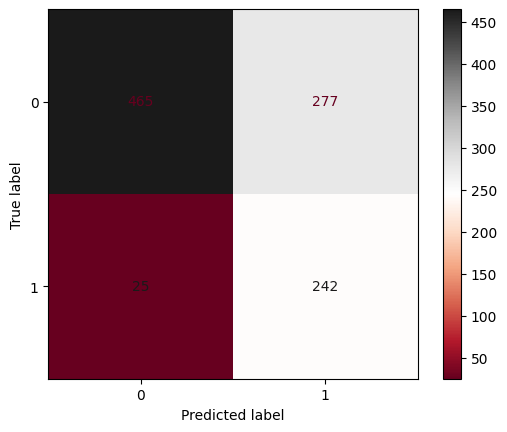

In [ ]:
#checking model prediction with adjusted threshold
# Develop Pipeline for Logistic Regression Model

threshold = 0.388918       #(fpr: 0.431267, tpr: 0.940075	)

# get logistic regression pipeline from all_pipeline
log_pipeline = all_pipeline['regression_classifier']

log_pred_proba = log_pipeline.predict_proba(X_trial)[:,1]

binary_prediction = log_pred_proba >= threshold

# get confusion matrix for Logistic Regression 
cmatrix2 = confusion_matrix(y_trial_encoded, binary_prediction)

#display confusion matrix
log_display2 = ConfusionMatrixDisplay(cmatrix2)
log_display2.plot(cmap= 'RdGy')
plt.show()


#### Hyperparameter tuning

In [ ]:
# Define a custom transformer for feature selection with SelectKBest
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, score_func=mutual_info_classif, k=5):
        self.score_func = score_func
        self.k = k
        self.selector = SelectKBest(score_func=self.score_func, k=self.k)

    def fit(self, X, y=None):
        self.selector.fit(X, y)
        return self

    def transform(self, X):
        return self.selector.transform(X)

# Define hyperparameters including the number of features (k)
hyper = {
    'feature_selection__score_func': [mutual_info_classif],  # Optionally vary score_func
    'feature_selection__k': [5, 8, 10, 15, 19],  # Vary k values using feature_selection__k
    'model__penalty': ['l2', 'l1'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__solver': ['lbfgs', 'liblinear', 'saga'],
    'model__max_iter': [200, 500, 1000, 2000, 5000]
}

# Create new pipeline for tuning
hypertuning_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Define 'preprocessor' if it's not done already
    ('feature_selection', FeatureSelector()),  # Include the custom FeatureSelector
    ('model', LogisticRegression(random_state=42))
])

# Create GridSearchCV with tuning pipeline
grid_search = GridSearchCV(hypertuning_pipeline, hyper, scoring='f1_weighted', cv=5)

# Apply GridSearchCV to data
grid_search.fit(X_train_resampled, y_train_resampled)

# Save best parameters and scores
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score (weighted F1):", best_score)

In [ ]:
#apply best parameters for log Regression to updated pipeline
LR_tuned = grid_search.best_estimator_
LR_tuned

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipeline',
                                                  Pipeline(steps=[('numeric_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log_tranformer',
                                                                   FunctionTransformer(func=<bound method LogTransformer.transform of <__main__.LogTransformer object at 0x000001D2C6283490>>)),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', '...
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('feature selection',
                 SelectKBest(score_func=<function mutual_info_classif at 0x000001D2C2450940>)),
                ('model',
                 SGDClassifier(alpha=0.01, loss='modified_huber', max_iter=3000,
                               penalty='l1', random_state=42))])

In [ ]:
LR_pred = LR_tuned.predict(X_trial)
print(classification_report(y_trial_encoded, LR_pred))


              precision    recall  f1-score   support

           0       0.89      0.76      0.82       742
           1       0.53      0.75      0.62       267

    accuracy                           0.76      1009
   macro avg       0.71      0.75      0.72      1009
weighted avg       0.80      0.76      0.77      1009



In [ ]:
SGD_original = Pipeline( steps = [
    ('preprocessor', preprocessor),
    ('feature_selection', selection ),
    ('model', SGDClassifier(random_state=42))
])
SGD_original.fit(X_train_resampled,y_train_resampled)
SGD_pred2 = SGD_original.predict(X_trial)
print(classification_report(y_trial_encoded, SGD_pred2))


              precision    recall  f1-score   support

           0       0.93      0.65      0.76       742
           1       0.47      0.87      0.61       267

    accuracy                           0.71      1009
   macro avg       0.70      0.76      0.69      1009
weighted avg       0.81      0.71      0.72      1009



In [ ]:
# get predicted probabilities
y_pred_prob2 = SGD_original.predict_proba(X_trial)[:,1]

#compute ROC curve
fpr2, tpr2, threshold2 = roc_curve(y_trial_encoded, y_pred_prob2)

# compute AUC score
AUC_score2 = roc_auc_score(y_trial_encoded, y_pred_prob2)


# Plot ROC Curve
plt.figure(figsize=(10, 4))
plt.plot(fpr2, tpr2, color='green', lw=2, label='ROC Curve (AUC = {:.2f})'.format(AUC_score))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Original Untuned Model')
plt.legend()
plt.show()

AttributeError: probability estimates are not available for loss='hinge'

#### Business Impact assessment and Model Documentation

#### Model Persistence

In [ ]:
joblib.dump(LR_tuned, 'Churn_Predictor.joblib')
joblib.jump(target_encoder, 'Encoder.joblib')